In [79]:
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
from datetime import date, datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
plt.style.use('seaborn-darkgrid')
rcParams['font.family'] = ['Heiti TC']
rcParams['figure.figsize'] = (12, 7)

# Google Trend Analysis

In [3]:
# To issue a google trend request we first init a TrendReq object:
pytrend = TrendReq(hl='en-US')

In [4]:
# Set the arguments needed to perform a trend query
keyword = 'vacation'
start = '2004-01-01'
end = '2020-12-31'
geo='US'
cat=0
gprop=''
start_d = datetime.strptime(start, '%Y-%m-%d')
end_d = datetime.strptime(end, '%Y-%m-%d')
tf = start_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')

In [5]:
# Get the payload from google trend
pytrend.build_payload(kw_list=[keyword], 
                      cat=cat, 
                      geo=geo, 
                      gprop=gprop, 
                      timeframe=tf)

df_trend = pytrend.interest_over_time()
df_trend.head()

,vacation,isPartial
date,,
2004-01-01,97,False
2004-02-01,90,False
2004-03-01,88,False
2004-04-01,81,False
2004-05-01,88,False


As you see, is contains a column "isPartial" which is set to true if the data for a given month is not complete. After checking for completness we can delete this column:

In [6]:
# remove the ispartial column... but only if all observations are not parial
if all(df_trend.isPartial == False):
    del df_trend['isPartial']

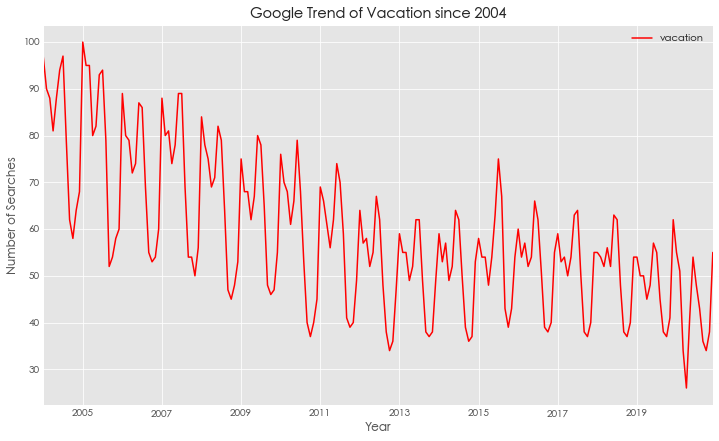

In [7]:
# Plot the time series of google searches of the word "vacation"
plt.style.use('ggplot')
ax = df_trend.plot(color='red', grid=True, figsize=(12,7))
ax.set_xlabel('Year')
ax.set_ylabel('Number of Searches')
ax.set_title('Google Trend of Vacation since 2004');

Notice that this series has a downrad trend. It has a predictable and repeated pattern due to seasonality

In [8]:
# save the data as csv for further using
df_trend.to_csv('../datasets/goog_trends.csv');

# Modelling Time Series

## Additive Model
An additive model is linear.  

y(t) = Level + Trend + Seasonality + Noise   

It is useful when the variations around the trend does not vary with the level of the time series. Components are added together.

## Multiplicative Model

A multiplicative model is non-linear: 

y(t) = Level x Trend x Seasonality x Noise

A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time. It is useful when the trend is proportional to the level of the time series. Components are multiplied together.

## Decomposing Time Series

### Application of Additive Model

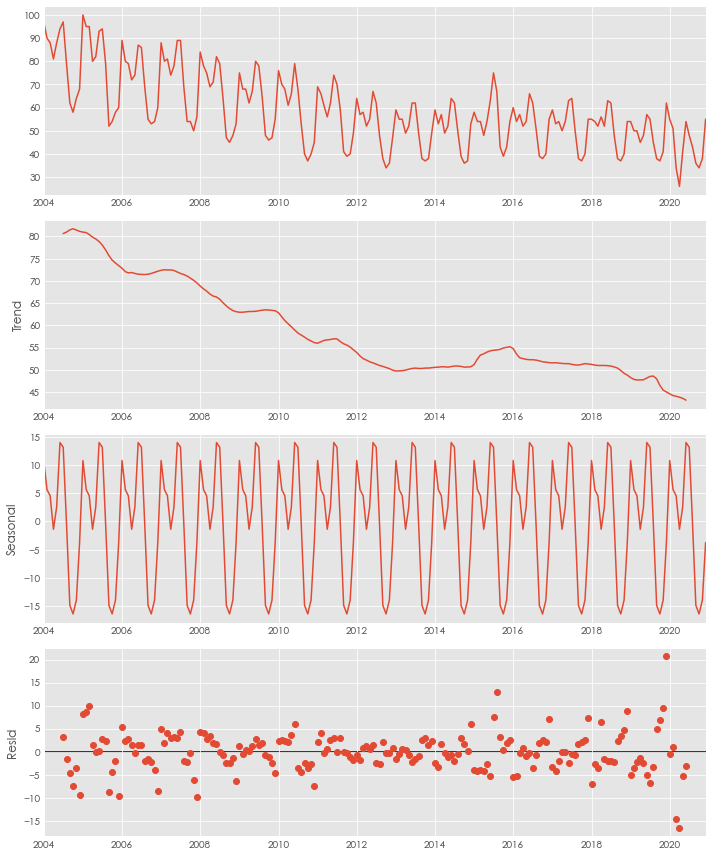

In [13]:
# freq is the number of data points in a repeated cycle
rcParams['figure.figsize'] = (10, 12)
result = seasonal_decompose(df_trend, model='additive', period=12)
fig = result.plot()

In [14]:
# Methods and variables of a statsmodels.tsa.seasonal.DecomposeResult object
[x for x in dir(result) if('_' not in x)]

['nobs', 'observed', 'plot', 'resid', 'seasonal', 'trend', 'weights']

### Application of Multiplicative Model

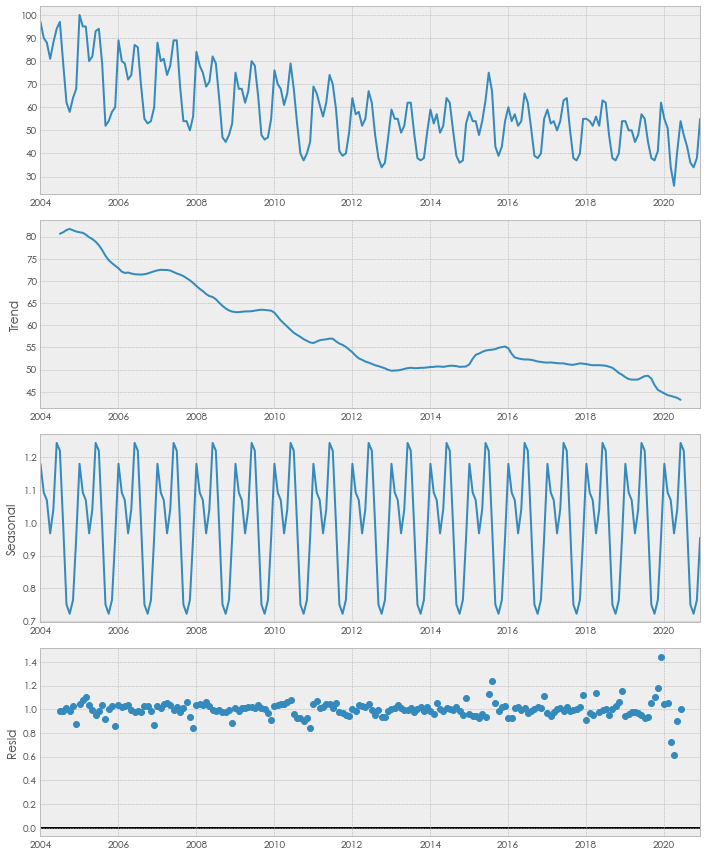

In [15]:
plt.style.use('bmh')
result = seasonal_decompose(df_trend, model='multiplicative', period=12)
fig = result.plot()

## Detrend and Deseasonalize a Time Series

When detrending and/or deseasonalizing a time series you may use one of the following approaches:
* differencing, substracting from the mean (or from a mean over period),
* calculating percentage change, or
* using a transformation such as a log transformation

A combination of the above mentioned approaches is also possible: For instance, you may take first difference and then a log transformation.

You can achieve stationarity when you remove trend and seasonality.  Stationarity of a times series is when you have constant mean and variance. It also means that autocovariance does not depend on time. Your time series should be stationary before applying any analysis. 

### Differencing

Differencing can help in reducing trends and seasonalities. 
It is done by subtracting away the previous period from the current period. 
Depending on your data sometimes you will have to try different forms of detrending and deseasonalizing approaches to reach the right outcome.

In [16]:
# Let's take again a look at our trend data set 
df_trend.sample(5)

,vacation
date,
2009-06-01,80
2015-02-01,54
2012-12-01,47
2018-08-01,48
2006-09-01,55


In [17]:
df_trend.describe().T

,count,mean,std,min,25%,50%,75%,max
vacation,204.0,58.872549,15.806198,26.0,48.0,55.0,68.0,100.0


In [18]:
df_trend['first_diff'] = df_trend.diff()
df_trend.dropna(inplace=True)
df_trend.describe().T

,count,mean,std,min,25%,50%,75%,max
vacation,203.0,58.684729,15.615400,26.0,48.0,55.0,68.0,100.0
first_diff,203.0,-0.206897,9.935263,-27.0,-6.0,-1.0,5.0,32.0


In [62]:
df_trend.head()

,vacation,first_diff,second_diff
date,,,
2004-04-01,81,-7.0,-9.0
2004-05-01,88,7.0,0.0
2004-06-01,94,6.0,13.0
2004-07-01,97,3.0,9.0
2004-08-01,79,-18.0,-15.0


Text(0.5, 1.0, 'Google Trends of Vacation')

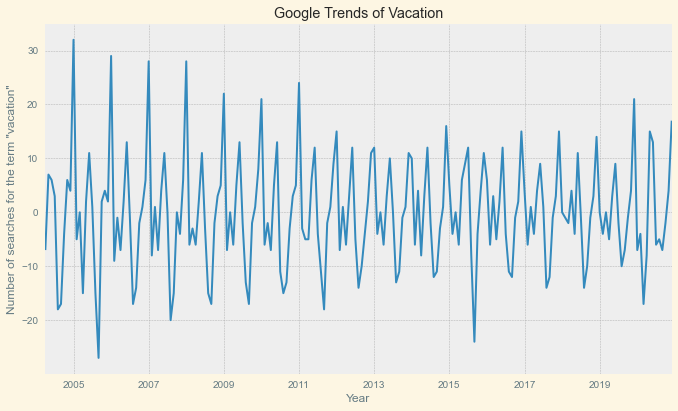

In [48]:
plt.style.use('bmh')
rcParams['figure.figsize'] = (10, 6)
ax = df_trend['first_diff'].plot();
ax.set_xlabel('Year')
ax.set_ylabel('Number of searches for the term "vacation"')
ax.set_title('Google Trends of Vacation')

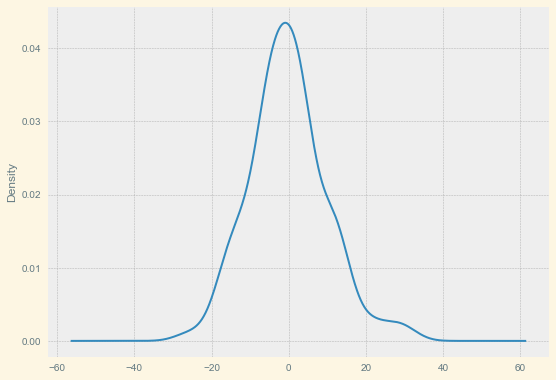

In [50]:
# Plot kernel density plot
rcParams['figure.figsize'] = (8, 6)
df_trend['first_diff'].plot(kind='kde');

In [46]:
df_trend['second_diff'] = df_trend['vacation'].diff(2)
df_trend.dropna(inplace=True)
df_trend.describe().T

,count,mean,std,min,25%,50%,75%,max
vacation,201.0,58.383085,15.394399,26.0,48.0,55.0,68.0,100.0
first_diff,201.0,-0.164179,9.972357,-27.0,-6.0,-1.0,5.0,32.0
second_diff,201.0,-0.422886,15.526277,-42.0,-11.0,-1.0,12.0,36.0


Comparing the mean and standard deviation between the first and second difference, the first difference gives better results and should be sufficient to detrend and deseasonalize the series.

## Autocorrelation

Autocorrelation (ACF), also known as serial correlation, is the correlation of a signal with a delayed copy of itself as a function of delay. Informally, it is the similarity between observations as a function of the time lag between them. The analysis of autocorrelation is a mathematical tool for finding repeating patterns, such as the presence of a periodic signal obscured by noise, or identifying the missing fundamental frequency in a signal implied by its harmonic frequencies.  
Unit root processes, trend-stationary processes, autoregressive processes, and moving average processes are specific forms of processes with autocorrelation. (see [wiki](https://en.wikipedia.org/wiki/Autocorrelation))

### White Noise

If your time series is statististically uncorrelated (independent) with zero mean and constant variance, then you have a particular type of noise called white noise. Indeed, the autocorrelation of a white noise will have a strong peak (represented by a Dirac delta function) at $\tau$ = 0 and will be exactly 0 for all other $\tau$

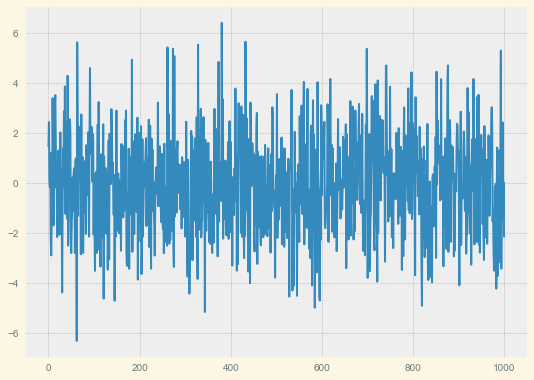

In [65]:
# Example of white noise
# loc is mean, scale is standard deviation
white_noise = np.random.normal(loc=0, scale=2, size=1000)

# plot white noise
plt.plot(white_noise);

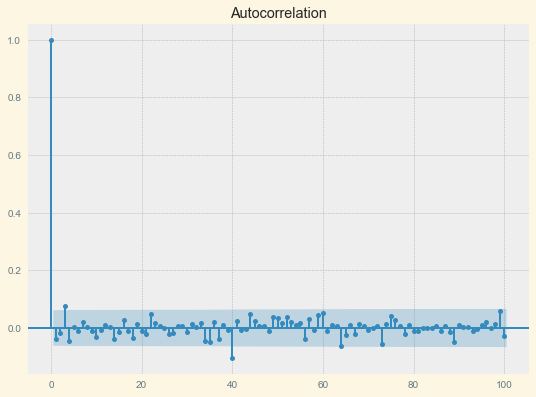

In [69]:
# Plot
plot_acf(white_noise, lags=100);

It is not possible to predict time series that have a white noise characteristic.

In [70]:
# Let's come back to our google trend data set:
vacation = pd.read_csv('../datasets/goog_trends.csv', 
                       parse_dates=['date'], 
                       index_col='date')
vacation.head()

,vacation
date,
2004-01-01,97
2004-02-01,90
2004-03-01,88
2004-04-01,81
2004-05-01,88


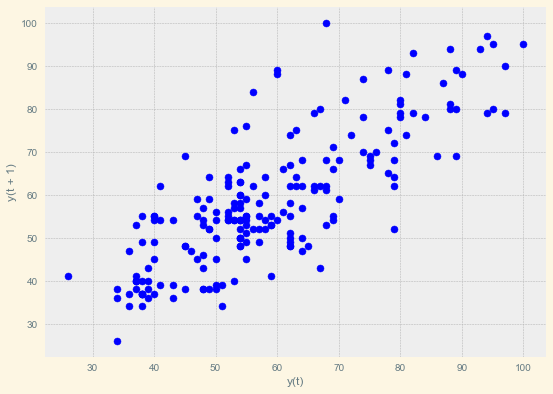

In [73]:
# Lag Plot
from pandas.plotting import lag_plot

lag_plot(vacation);

The plot above shows the vacation data on the y(t) against its previous time step, prior month, the the y(t+1). You can think of the data shifted by a month and then plotted, removing the first data point.  
Clearly, we see a positive relationship, though it is has a broader range of scatter.

In [76]:
# Autocorrelation
autocorrelation = vacation['vacation'].autocorr()
print("The autocorrelation is: %4.2f" %(autocorrelation))

The autocorrelation is: 0.80


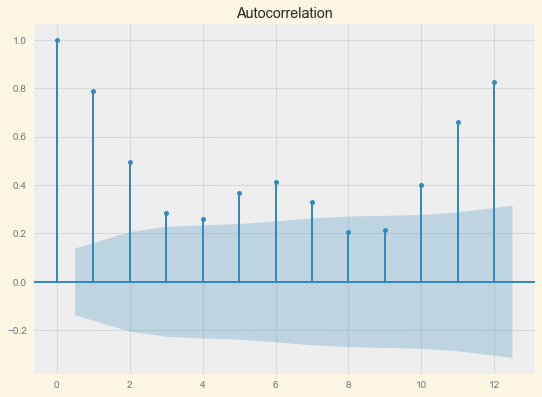

In [77]:
# Plot ACF 
plot_acf(vacation, lags=12);

## Partial Autocorrelation Function (PACF)

Partial correlation measures the degree of association between two random variables, with the effect of a set of controlling random variables removed. If we are interested in finding to what extent there is a numerical relationship between two variables of interest, using their correlation coefficient will give misleading results if there is another, confounding, variable that is numerically related to both variables of interest. This misleading information can be avoided by controlling for the confounding variable, which is done by computing the partial correlation coefficient.  
For example, if we have economic data on the consumption, income, and wealth of various individuals and we wish to see if there is a relationship between consumption and income, failing to control for wealth when computing a correlation coefficient between consumption and income would give a misleading result, since income might be numerically related to wealth which in turn might be numerically related to consumption; a measured correlation between consumption and income might actually be contaminated by these other correlations. The use of a partial correlation avoids this problem.

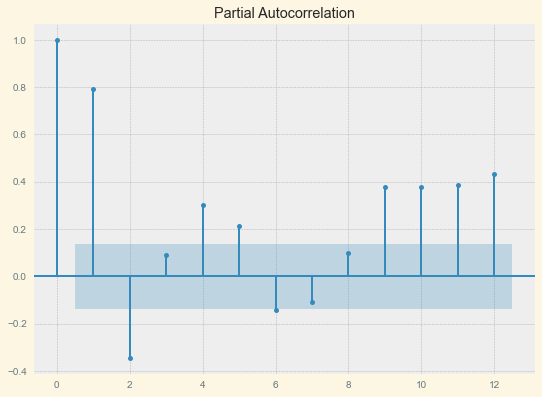

In [80]:
# Parial autocorrelation
plot_pacf(vacation['vacation'], lags=12);

The blue shaded regions represent a confidence interval. If the PACF values are beyond this confidence interval regions, then you can assume that the observed partial autocorrelation values are satistically significant.